In [3]:
path = "./u.data"
import pandas as pd
df = pd.read_csv(path, sep="\t")

In [4]:
df.columns

Index(['196', '242', '3', '881250949'], dtype='object')

In [5]:
df.shape

(99999, 4)

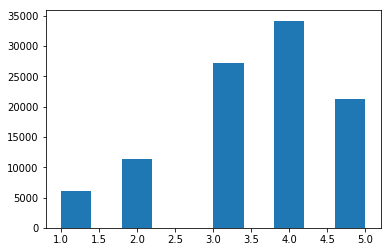

In [6]:
import matplotlib.pyplot as plt
df.columns = ["UserId","MovieId","Rating","TimeStamp"]
plt.hist(df["Rating"])
plt.show()


In [7]:
#df.nunique(axis = 0)



In [8]:
df.groupby(["Rating"]).count()

,UserId,MovieId,TimeStamp
Rating,,,
1,6110,6110,6110
2,11370,11370,11370
3,27144,27144,27144
4,34174,34174,34174
5,21201,21201,21201


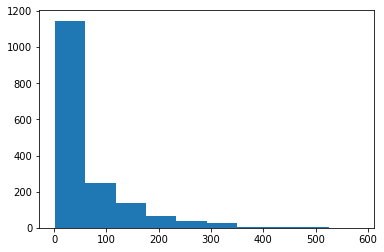

In [9]:
a = df.groupby(["MovieId"])["MovieId"].count()
type(a)
plt.hist(a)
plt.show()

In [10]:
n_users = df.UserId.unique().shape[0]
n_users

n_movie = df.MovieId.unique().shape[0]
n_movie

1682

In [11]:
#把需要的数据transform
import numpy as np
ratings = np.zeros((n_users, n_movie))
ratings.shape
for row in df.itertuples():
    #print(row,row[1],row[2])
    ratings[ row[1]-1, row[2]-1] = row[3]
print(ratings)

[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


In [12]:
sparsity =  float(len(ratings.nonzero()[0]))
sparsity /= ratings.shape[0] * ratings.shape[1] 
sparsity *= 100
print("sparsity:{:4.2f}%".format(sparsity))


sparsity:6.30%


In [13]:
from sklearn.cross_validation import train_test_split

/home/robin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
ratings_train , ratings_test = train_test_split(ratings, test_size = 0.3 , random_state = 42)
print(ratings_train.shape , ratings_test.shape)

(660, 1682) (283, 1682)


In [15]:
import numpy as np
import sklearn
dist_out = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)
print(type(dist_out))
print(dist_out.shape)
#print(dist_out[20])


<class 'numpy.ndarray'>
(660, 660)


In [16]:
t1 = dist_out.dot(ratings_train)
print(t1.shape , t1[1])
t2 = np.abs(dist_out).sum(axis=1)
print(t2.shape , t2[1])
t2 = np.array([t2]).T
print(t2.shape , t2[1])
user_pred = t1 / t2
print(user_pred.shape , user_pred[0])


(660, 1682) [ 126.7267968    26.23195324   24.09479198 ...,    0.            0.31491095
    0.20938183]
(660,) 89.8783000884
(660, 1) [ 89.87830009]
(660, 1682) [ 2.10269053  0.58700196  0.34027925 ...,  0.          0.00733644
  0.00604406]


In [17]:
from sklearn.metrics import mean_squared_error
def get_mse(pred ,actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred , actual)
get_mse(user_pred , ratings_train)

7.87824424912976

In [18]:
print(user_pred.shape , ratings_test.shape)
get_mse(user_pred , ratings_test)

(660, 1682) (283, 1682)


8.7450666635985748

In [27]:
#UCF  k-nearest
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(660 , 'cosine')
neigh.fit(ratings_train) 
top_k_distances,top_k_users = neigh.kneighbors(ratings_train, return_distance=True) 
top_k_distances.shape


(660, 660)

In [28]:
user_pred_k = np.zeros(ratings_train.shape) 
for i in range(ratings_train.shape[0]):  
    print("i",i,ratings_train[top_k_users][i].shape)
    user_pred_k[i,:] =   top_k_distances[i].T.dot(ratings_train[top_k_users][i]) /np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T
get_mse(user_pred_k, ratings_train) 


MemoryError: 

In [111]:
get_mse(user_pred_k, ratings_test) 


11.246270314570966

In [123]:
#ICF
k = ratings_train.shape[1] 
neigh = NearestNeighbors(k,'cosine') 
neigh.fit(ratings_train.T) 
top_k_distances,top_k_users = neigh.kneighbors(ratings_train.T, return_distance=True) 
top_k_distances.shape 

item_pred = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)]) 
item_pred.shape


(660, 1682)

In [124]:
item_pred 

array([[ 0.        ,  0.31842066,  0.37008695, ...,  1.44850452,
         1.45663986,  1.54530927],
       [ 0.        ,  0.05453799,  0.06227966, ...,  0.20078779,
         0.20112163,  0.21332553],
       [ 0.        ,  0.03522485,  0.04073134, ...,  0.18456975,
         0.18654732,  0.20076379],
       ..., 
       [ 0.        ,  0.08967314,  0.10312478, ...,  0.42049434,
         0.41959933,  0.45862876],
       [ 0.        ,  0.25835797,  0.29918177, ...,  1.31043883,
         1.3227857 ,  1.4139122 ],
       [ 0.        ,  0.07174789,  0.08538041, ...,  0.25535296,
         0.25259741,  0.26199751]])

In [125]:
get_mse(item_pred, ratings_train) 

11.172607811752975

In [126]:
get_mse(item_pred,ratings_test)

11.876805077540418